### Check conservation: total atmosphere mass, total axial angular momentum, total kinetic energy

In [1]:
from pathlib import Path

import iris
import iris.pandas
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib.lines import Line2D

In [2]:
from util_commons import PLANETS, ROSE_SUITES
from util_mypaths import path_to_data_umserve

In [3]:
rcParams["mathtext.default"] = "regular"

In [4]:
def load_conservation_diag(fnames, convert_to_iris=True):
    """Load conservation diagnostics."""
    dset = pd.concat(
        map(
            lambda fpath: pd.read_csv(fpath, header=None, sep=r"\s+"),
            fnames,
        )
    )
    dset = dset.drop_duplicates()
    dset = (
        dset.rename(
            {
                0: "timestep",
                1: "total_atmosphere_mass",
                2: "total_axial_angular_momentum",
                3: "total_kinetic_energy",
            },
            axis="columns",
        )
        .sort_values(by="timestep")
        .set_index("timestep")
    )
    if convert_to_iris:
        dset = iris.pandas.as_cubes(dset)
        cube = dset.extract_cube("total_atmosphere_mass")
        cube.units = "kg"
        cube = dset.extract_cube("total_axial_angular_momentum")
        cube.units = "kg m**2 s**-1"
        cube = dset.extract_cube("total_kinetic_energy")
        cube.units = "kg m**2 s**-2"
    return dset

In [5]:
# Parameters
planet = "wasp96b"
path_to_planet = path_to_data_umserve / "um_runs" / planet
path_to_project = Path.home() / "projects" / planet

In [6]:
# Assemble data
vrbls = {}
for exp in ["equilibrium", "kinetics"]:
    vrbls[exp] = {}
    for mdh in ["mdh_0", "mdh_1"]:
        vrbls[exp][mdh] = {}
        # Stronger (tK_1) and weaker (tK_6) diffusion
        for tK in ["tK_1", "tK_6"]:
            vrbls[exp][mdh][tK] = {}
            rose_suite = ROSE_SUITES[planet][exp][mdh][tK]["rose_suite"]
            path_to_check = path_to_planet / exp / rose_suite / "check"
            tam, taam, tke = load_conservation_diag(
                sorted(path_to_check.glob("*/conservation_diag.dat")), convert_to_iris=True
            )
            vrbls[exp][mdh][tK] = {
                "rose_suite": rose_suite,
                "tam": tam,
                "taam": taam,
                "tke": tke,
            }

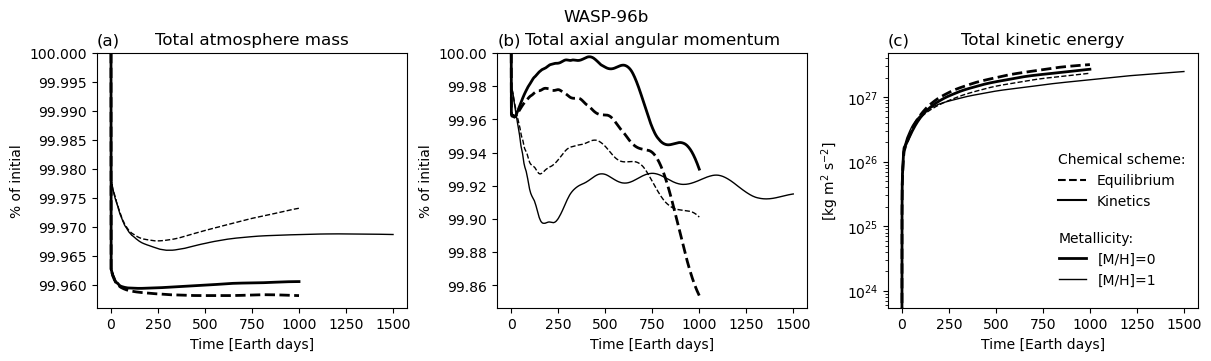

In [7]:
# Plot WASP-96b tK=6 only
tK = "tK_6"
exp_lines = [
    Line2D([0], [0], color="k", ls="--"),
    Line2D([0], [0], color="k", ls="-"),
]
mdh_lines = [
    Line2D([0], [0], color="k", ls="-", lw=2),
    Line2D([0], [0], color="k", ls="-", lw=1),
]

fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, constrained_layout=True, figsize=(12, 3.5))
for exp, ls in zip(["equilibrium", "kinetics"], ["dashed", "solid"]):
    for mdh, lw in zip(["mdh_0", "mdh_1"], [2, 1]):
        plt_tam = vrbls[exp][mdh][tK]["tam"].data / vrbls[exp][mdh][tK]["tam"].data[0] * 100
        plt_taam = vrbls[exp][mdh][tK]["taam"].data / vrbls[exp][mdh][tK]["taam"].data[0] * 100
        plt_tke = vrbls[exp][mdh][tK]["tke"].data
        coord_in_days = vrbls[exp][mdh][tK]["tam"].coord("timestep").points / 2880
        ax[0].plot(coord_in_days, plt_tam, color="k", ls=ls, lw=lw)
        ax[1].plot(coord_in_days, plt_taam, color="k", ls=ls, lw=lw)
        ax[2].plot(coord_in_days, plt_tke, color="k", ls=ls, lw=lw)
ax[0].set_title("(a)", loc="left")
ax[1].set_title("(b)", loc="left")
ax[2].set_title("(c)", loc="left")
ax[0].set_title("Total atmosphere mass", loc="center")
ax[1].set_title("Total axial angular momentum", loc="center")
ax[2].set_title("Total kinetic energy", loc="center")
for iax in ax.flatten():
    iax.set_xlabel("Time [Earth days]")
ax[0].set_ylabel("% of initial")
ax[1].set_ylabel("% of initial")
ax[2].set_ylabel("[kg $m^2$ $s^{-2}$]")
ax[0].set_ylim(top=100)
ax[1].set_ylim(top=100)
ax[2].set_yscale("log")
# Legends
exp_leg = ax[2].legend(
    exp_lines,
    ["Equilibrium", "Kinetics"],
    title="Chemical scheme:",
    frameon=False,
    alignment="left",
    loc="center right",
)
axleg = ax[2].add_artist(exp_leg)
mdh_leg = ax[2].legend(
    mdh_lines,
    ["[M/H]=0", "[M/H]=1"],
    title="Metallicity:",
    frameon=False,
    alignment="left",
    bbox_to_anchor=(0.905, 0.35),
)
fig.suptitle(f"{PLANETS[planet]['tex']}")
figname_png = f"{planet}_conservation_tK{tK[-1]}.png"
figname_pdf = f"{planet}_conservation_tK{tK[-1]}.pdf"
fig.savefig(path_to_project / "conservation" / figname_png, dpi=200)
fig.savefig(path_to_project / "conservation" / figname_pdf, format="pdf")

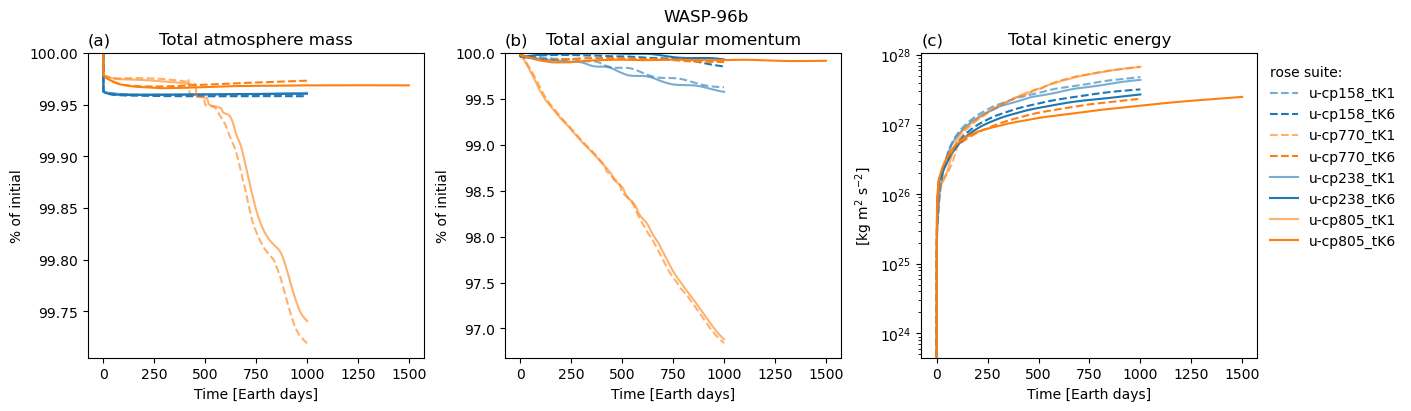

In [8]:
# Plot all WASP-96b simulations
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharex=True, constrained_layout=True)
for exp, ls in zip(["equilibrium", "kinetics"], ["dashed", "solid"]):
    for mdh, clr in zip(["mdh_0", "mdh_1"], ["C0", "C1"]):
        for tK, alpha in zip(["tK_1", "tK_6"], [0.6, 1]):
            plt_tam = vrbls[exp][mdh][tK]["tam"].data / vrbls[exp][mdh][tK]["tam"].data[0] * 100
            plt_taam = vrbls[exp][mdh][tK]["taam"].data / vrbls[exp][mdh][tK]["taam"].data[0] * 100
            plt_tke = vrbls[exp][mdh][tK]["tke"].data
            coord_in_days = vrbls[exp][mdh][tK]["tam"].coord("timestep").points / 2880
            ax[0].plot(coord_in_days, plt_tam, ls=ls, color=clr, alpha=alpha)
            ax[1].plot(coord_in_days, plt_taam, ls=ls, color=clr, alpha=alpha)
            ax[2].plot(
                coord_in_days,
                plt_tke,
                ls=ls,
                color=clr,
                alpha=alpha,
                label=vrbls[exp][mdh][tK]["rose_suite"],
            )
ax[0].set_title("(a)", loc="left")
ax[1].set_title("(b)", loc="left")
ax[2].set_title("(c)", loc="left")
ax[0].set_title("Total atmosphere mass", loc="center")
ax[1].set_title("Total axial angular momentum", loc="center")
ax[2].set_title("Total kinetic energy", loc="center")
for iax in ax.flatten():
    iax.set_xlabel("Time [Earth days]")
ax[0].set_ylabel("% of initial")
ax[1].set_ylabel("% of initial")
ax[2].set_ylabel("[kg $m^2$ $s^{-2}$]")
ax[0].set_ylim(top=100)
ax[1].set_ylim(top=100)
ax[2].set_yscale("log")
ax[2].legend(title="rose suite:", frameon=False, alignment="left", bbox_to_anchor=(1, 1))
fig.suptitle(f"{PLANETS[planet]['tex']}")
figname = f"{planet}_conservation_all.png"
fig.savefig(path_to_project / "conservation" / figname, dpi=200)